In [420]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# And some functions we will need
from scipy.special import logit
from statsmodels.discrete.discrete_model import Logit

# start by bringing in the dataset from the previous step
set_df = pd.read_pickle("../data/set_df.pkl")
elevation_xa = pd.read_pickle("../data/elevation_xa.pkl")
species_df = pd.read_pickle("../data/species_df.pkl")
species_code_lookup = pd.read_pickle("../data/species_code_lookup.pkl")

# now we will want to create a dict to manage every we want to run in the logistic regressions
# species_dict = dict()
# for key in species_code_lookup.keys():
#     species_dict[key] = dict(name=species_code_lookup[key], predictors=)
# 
default_predictors = ['latitude', 'longitude', 'elevation']
species_dict = {
    'American plaice': {"predictors": default_predictors},
    'Atlantic cod': {"predictors": default_predictors},
    'Atlantic herring': {"predictors": default_predictors},
    'Redfish unidentified': {"predictors": default_predictors},
    'American lobster': {"predictors": default_predictors},
    'Snow crab': {"predictors": default_predictors},
}

In [421]:
set_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7257 entries, 11 to 166605
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   set_id                7257 non-null   int64         
 1   latitude              7257 non-null   float64       
 2   longitude             7257 non-null   float64       
 3   dt                    7257 non-null   datetime64[ns]
 4   elevation             7257 non-null   int64         
 5   American plaice       7257 non-null   bool          
 6   Atlantic cod          7257 non-null   bool          
 7   Atlantic herring      7257 non-null   bool          
 8   Redfish unidentified  7257 non-null   bool          
 9   American lobster      7257 non-null   bool          
 10  Snow crab             7257 non-null   bool          
dtypes: bool(6), datetime64[ns](1), float64(2), int64(2)
memory usage: 382.7 KB


In [422]:

# For each species, we will fit a model
species_list = list(species_dict.keys())
for species in species_list:
    mydict = species_dict[species]
    predictors = mydict["predictors"]
    m = Logit(set_df[species], set_df[predictors])
    m = m.fit()
    mydict["model"] = m


Optimization terminated successfully.
         Current function value: 0.359037
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422426
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.278567
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.210431
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.621462
         Iterations 5


In [423]:

# Let's get a table of the parameter estimations for each species and indicate whether or not they are significant
param_df = pd.DataFrame(columns=default_predictors)


def get_coef_display(row):
    mystr = str(round(row["Coef."], 4))
    p = row["P>|z|"]
    if p <= 0.001:
        mystr += " [***]"
    elif p <= 0.01:
        mystr += " [**]"
    elif p <= 0.05:
        mystr += " [*]"
    return mystr


for species in species_list:
    m = species_dict[species]["model"]
    summary = m.summary2()
    temp_param_df = summary.tables[1]
    params = temp_param_df.apply(get_coef_display, axis=1)
    param_df.loc[species, :] = params

param_df

,latitude,longitude,elevation
American plaice,0.8952 [***],0.6299 [***],0.0099 [***]
Atlantic cod,0.5393 [***],0.3637 [***],0.0131 [***]
Atlantic herring,-1.0332 [***],-0.7718 [***],-0.0003
Redfish unidentified,0.1389 [**],0.1823 [***],-0.041 [***]
American lobster,-0.9447 [***],-0.7466 [***],0.1009 [***]
Snow crab,0.5095 [***],0.3746 [***],0.0001


In [424]:

# based on the above, we will not use the `elevation` predictor for herring and snowcrab models

species_dict["Atlantic herring"]["predictors"] = ["latitude", "longitude"]
species_dict["Snow crab"]["predictors"] = ["latitude", "longitude"]

# and now we will have to re-run the models
for species in species_list:
    mydict = species_dict[species]
    predictors = mydict["predictors"]
    m = Logit(set_df[species], set_df[predictors])
    m = m.fit()
    mydict["model"] = m


Optimization terminated successfully.
         Current function value: 0.359037
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422426
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.278567
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.210431
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.621467
         Iterations 5


In [425]:

for species in species_list:
    set_df[f"p_{species}"] = species_dict[species]["model"].predict(set_df[species_dict[species]["predictors"]])

set_df.head()



,set_id,latitude,longitude,dt,elevation,American plaice,Atlantic cod,Atlantic herring,Redfish unidentified,American lobster,Snow crab,p_American plaice,p_Atlantic cod,p_Atlantic herring,p_Redfish unidentified,p_American lobster,p_Snow crab
11,1,47.966667,-65.116667,1971-09-07 11:15:00,-87,True,True,False,False,False,False,0.742560,0.739406,0.669603,0.161558,0.004147,0.510553
23,2,47.933333,-65.250000,1971-09-07 12:45:00,-73,True,True,False,False,False,False,0.747351,0.761369,0.698959,0.095442,0.019126,0.493988
24,3,47.916667,-65.516667,1971-09-07 15:05:00,-48,True,True,True,False,False,False,0.759498,0.799379,0.743287,0.034769,0.231495,0.467207
0,4,48.016667,-64.766667,1971-09-07 08:25:00,-80,True,True,True,False,False,False,0.801242,0.783987,0.595767,0.134403,0.006161,0.549154
35,5,48.216667,-64.483333,1971-09-08 10:25:00,-96,True,True,False,False,False,False,0.830994,0.784135,0.491723,0.244544,0.000826,0.599461


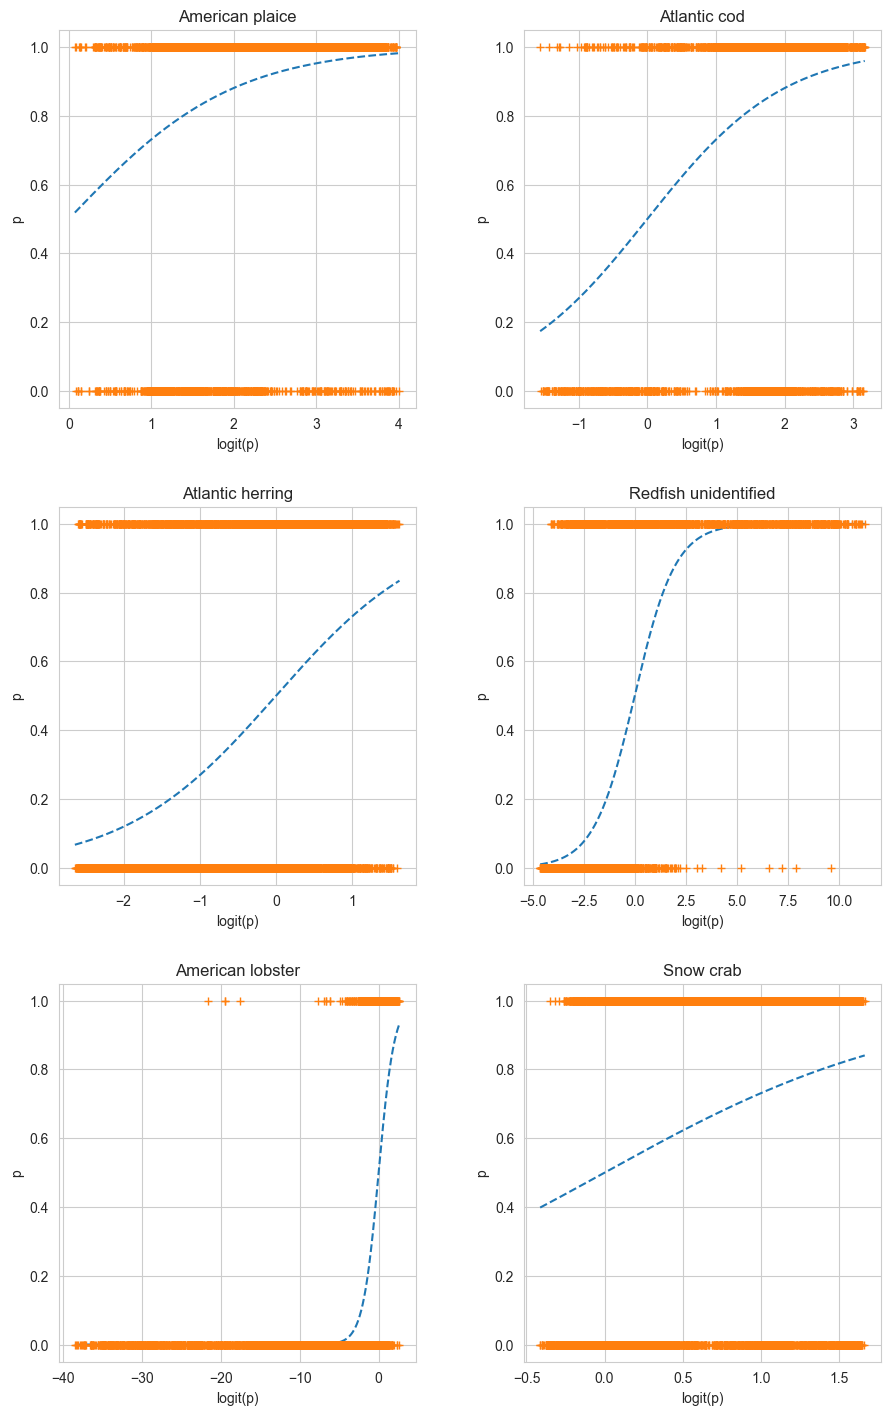

In [438]:

# plot relationship between values of logit(p) and p
# we will also display the actual values of the response

# create the figure and plot
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(10, 15))
fig.tight_layout(pad=5)
axs = [ax1, ax2, ax3, ax4, ax5, ax6]


def generate_logit_plot(ax, species):
    p_attr = f'p_{species}'
    temp_df = set_df.sort_values(p_attr)
    ax.plot(logit(temp_df[p_attr]), temp_df[p_attr], '--')
    ax.plot(logit(temp_df[p_attr]), temp_df[species], '+')
    ax.set_title(species)
    ax.set_xlabel('logit(p)')
    ax.set_ylabel('p')


for i in range(0, 6):
    generate_logit_plot(axs[i], species_list[i])

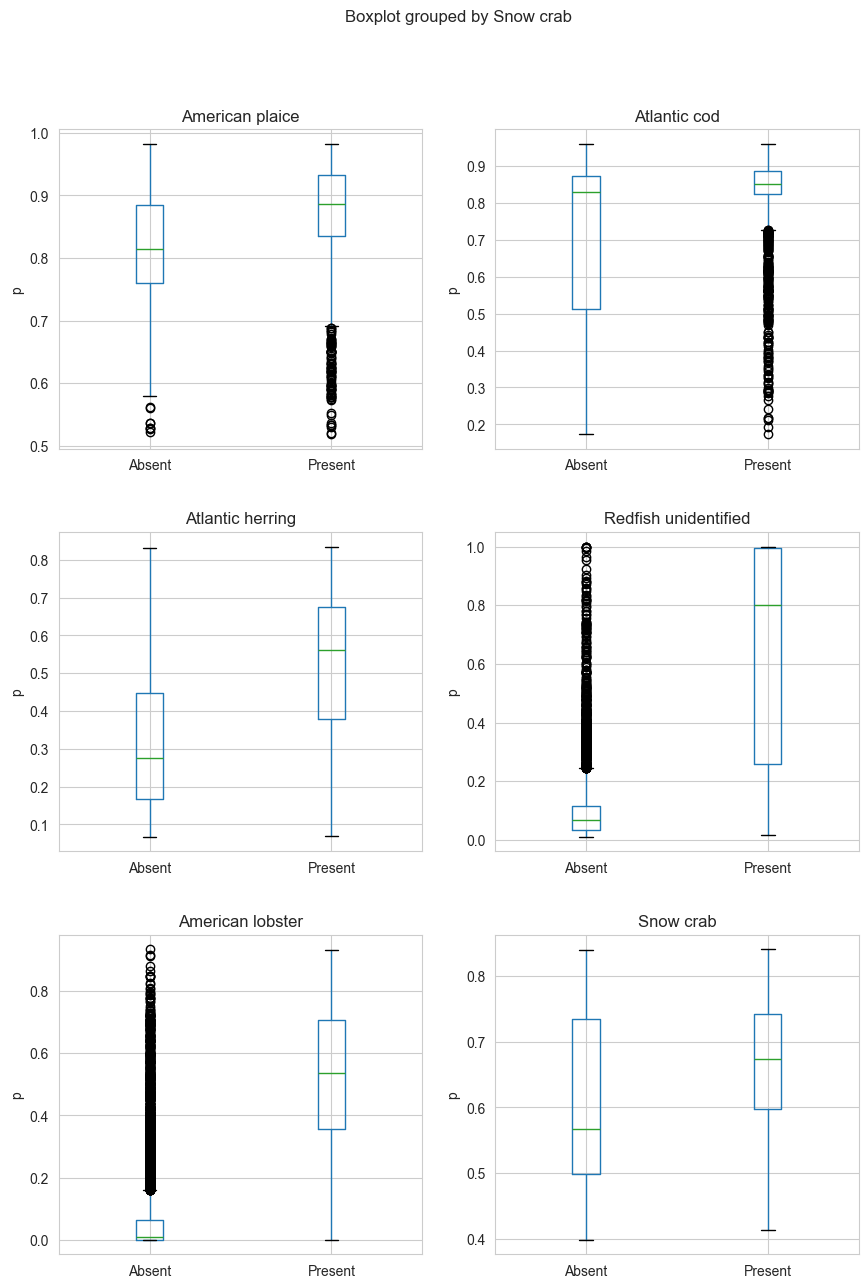

In [446]:

# create a box plot of the distribution of estimated odds for both values of the actual response

# create the figure and plot
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(10, 15))
fig.tight_layout(pad=5)
axs = [ax1, ax2, ax3, ax4, ax5, ax6]


def generate_boxplot(ax, species):
    p_attr = f'p_{species}'
    temp_df = set_df.sort_values(p_attr)
    temp_df.boxplot(p_attr, species, ax=ax)
    ax.set_title(species)
    ax.set_xticks([1, 2], ['Absent', 'Present'])
    ax.set_xlabel('')
    ax.set_ylabel('p')


for i in range(0, 6):
    generate_boxplot(axs[i], species_list[i])

In [ ]:

# In looking at the above, we can see the distribution of estimated odds for each level of the actual response. For example, it can be noted that in Species like redfish and lobster, the model seems to be doing a very good job in predicting the odds. In lobster, in cases where lobster was absent, the average model odds estimate was close to zero. In other species, the model did not do a good job in explaining this. 


In [447]:

# let's create a table that presents the ACC, MCC, Precision and Recall

eval_df = pd.DataFrame(columns=["ACC", "MCC", "Precision", "Recall"])
# 
# for species in species_list:
#     m = species_dict[species]["model"]
#     summary = m.summary2()
#     temp_param_df = summary.tables[1]
#     params = temp_param_df.apply(get_coef_display, axis=1)
#     param_df.loc[species, :] = params
# 
# param_df

summary

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Method:           MLE       
Dependent Variable: Snow crab        Pseudo R-squared: 0.045     
Date:               2024-04-13 11:51 AIC:              9025.9000 
No. Observations:   7257             BIC:              9046.5692 
Df Model:           2                Log-Likelihood:   -4510.0   
Df Residuals:       7254             LL-Null:          -4721.6   
Converged:          1.0000           LLR p-value:      1.1625e-92
No. Iterations:     5.0000           Scale:            1.0000    
-------------------------------------------------------------------
            Coef.    Std.Err.      z      P>|z|     [0.025   0.975]
-------------------------------------------------------------------
latitude    0.5095     0.0314   16.2425   0.0000    0.4480   0.5709
longitude   0.3746     0.0233   16.0904   0.0000    0.3289   0.4202
elevation   0.0001     0.0005    0.2757   0.7828   -0.0008   0.0011
=================================================================

"""

In [ ]:
conf_mat = m.pred_table()
conf_mat

In [ ]:
tn, fp, fn, tp = conf_mat.flatten()
print(tn, fp, fn, tp)

In [ ]:
acc = (tp + tn) / np.sum(conf_mat)
print("Accuraccy of the model is: %1.2f" % acc)

In [ ]:
mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
print("Mathews correlation coefficient between the estimates and the true response is: %1.2f" % mcc)

In [ ]:
prc = tp / (tp + fp)
rec = tp / (tp + fn)
print("Model's precision is %1.2f and it's recall is %1.2f" % (prc, rec))

In [ ]:
# Set discrimination thresholds
ths = np.arange(0., 1.0, 0.025)

# Containers
sensitivity = []
specificity = []
accuracy = []
matthews = []

# Main loop
for th in ths:
    # Generate estimates
    conf_mat = m.pred_table(threshold=th)

    # Extract TN, FP, ...
    tn, fp, fn, tp = conf_mat.flatten()

    # Calculate sensitivity and specificity
    sens = (1. * tp) / (tp + fn)
    spec = (1. * tn) / (tn + fp)

    # Calculate ACC and MCC
    acc = (tp + tn) / np.sum(conf_mat)
    mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    # Add to containers
    sensitivity.append(sens)
    specificity.append(spec)
    accuracy.append(acc)
    matthews.append(mcc)

In [ ]:
# Bind all the numbers together
roc = pd.DataFrame({'discret_thr': ths,
                    'sensitivity': sensitivity,
                    'specificity': specificity,
                    '_specificity': [1 - x for x in specificity],
                    'accuracy': accuracy,
                    'matthews': matthews})

# Sort by 1 - specificity so we can plot it easily
roc = roc.sort_values(by="_specificity")

In [ ]:
plt.plot(roc._specificity, roc.sensitivity, label='ROC')
plt.plot(np.arange(0., 1., 0.01),
         np.arange(0., 1., 0.01),
         '--')

plt.legend(loc=4)

In [ ]:
auc = np.trapz(y=roc.sensitivity, x=roc._specificity)
print("Area under ROC curve = %1.2f" % auc)


In [ ]:
# Where threshold equal 0.5
idx_default_th = np.where(roc.discret_thr == 0.5)[0][0]

# Max sum of spec and sens
idx_youdensj = np.argmax(roc.sensitivity + roc.specificity)

# Balanced spec and sens
idx_ballance = np.argmin(np.abs(roc.sensitivity - roc.specificity))

In [ ]:
plt.plot(roc._specificity, roc.sensitivity, label='ROC')

plt.plot(np.arange(0., 1., 0.01),
         np.arange(0., 1., 0.01),
         '--')

plt.plot(roc._specificity[idx_default_th],
         roc.sensitivity[idx_default_th],
         's', color='blue',
         label='Default')

plt.plot(roc._specificity[idx_youdensj],
         roc.sensitivity[idx_youdensj],
         's', color='red',
         label='Max(Spec. + Sens.)')

plt.plot(roc._specificity[idx_ballance],
         roc.sensitivity[idx_ballance],
         's', color='green',
         label='Spec. = Sens.')

plt.legend(loc=4)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()


In [ ]:
m.pred_table(threshold=roc.discret_thr[idx_youdensj])


In [ ]:
m.pred_table(threshold=roc.discret_thr[idx_ballance])


In [ ]:
J = max(roc.sensitivity + roc.specificity - 1)
print('Youden\'s J = %1.2f' % J)

In [ ]:
print('Odds mean: %1.2f' % np.mean(df['p']))
print('Response mean: %1.2f' % np.mean(df[species]))

In [ ]:
print('Predicted positives #: %i' % np.sum(df['p'] > 0.5))
print('True positives #: %i' % np.sum(df[species] > 0.5))

In [ ]:
print(conf_mat)

In [ ]:
# Predicted negatives and positives
conf_mat.sum(axis=0)

In [ ]:
# Actual negatives and positives
conf_mat.sum(axis=1)

In [ ]:
plt.plot(roc.discret_thr, roc.accuracy, 'x-')
plt.xlabel('Discrimination threshold')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
plt.plot(roc.discret_thr, roc.matthews, 'x-')
plt.xlabel('Discrimination threshold')
plt.ylabel('MCC')
plt.show()

In [ ]:
idx_maxacc = np.argmax(roc.accuracy)
idx_maxmcc = np.argmax(roc.matthews)

plt.plot(roc._specificity, roc.sensitivity, label='ROC')

plt.plot(np.arange(0., 1., 0.01),
         np.arange(0., 1., 0.01),
         '--')

plt.plot(roc._specificity[idx_default_th],
         roc.sensitivity[idx_default_th],
         's', color='blue',
         label='Default')

plt.plot(roc._specificity[idx_youdensj],
         roc.sensitivity[idx_youdensj],
         's', color='red',
         label='Max(Spec. + Sens.)')

plt.plot(roc._specificity[idx_ballance],
         roc.sensitivity[idx_ballance],
         's', color='green',
         label='Spec. = Sens.')

plt.plot(roc._specificity[idx_maxacc],
         roc.sensitivity[idx_maxacc],
         's', color='purple',
         label='Max. Accuracy')

plt.plot(roc._specificity[idx_maxmcc],
         roc.sensitivity[idx_maxmcc],
         '^', color='cyan',
         label='Max. MCC')

plt.legend(loc=4)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()


In [ ]:


elevation_df = elevation_xa.to_dataframe()
elevation_df = elevation_df.reset_index()
elevation_df['p'] = m.predict(elevation_df[["lat", "lon", "elevation"]])

elevation_df



In [ ]:
prob_array = elevation_df["p"].to_numpy()

In [ ]:
prob_array = prob_array.reshape(elevation_xa.data.shape)

prob_xa = elevation_xa.copy()

prob_xa.data = prob_array




In [ ]:
dir(prob_xa)


In [ ]:
prob_xa.attrs

In [ ]:
prob_xa.attrs["long_name"] = "Probability of presence"
prob_xa.attrs["units"] = "p"

In [ ]:
from geopandas import GeoDataFrame
from shapely import Point
import geopandas as gpd

fig, ax = plt.subplots()

prob_xa.plot(ax=ax, cmap="gist_heat")

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)
gdf = gdf.set_crs(epsg=4326)

pmask = gdf[species] == True
amask = gdf[species] == False
gdf[pmask].plot(ax=ax, marker="o", color='blue', markersize=1, label="present")
# gdf[amask].plot(ax=ax, marker="o", color='red', markersize=1, label="absent")


# this geojson is from here: https://open.canada.ca/data/en/dataset/85efc01b-163f-ebba-2378-c43eadfb3b3f
canada = gpd.read_file("../data/Canada_Provinical_boundaries_April2022_3931220444258526365.geojson")
# it is in a weird projection
canada = canada.to_crs(epsg=4326)
# create the figure and plot

# start by plotting the two geospatial dfs
# gdf.plot(ax=ax, color='red', markersize=2)
canada.plot(ax=ax, color='grey')

# set graph props
ax.set_title(f'Distribution Map of {species.title()}', fontsize=10)
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize='medium')
ax.set_xlim((np.min(df["longitude"]), np.max(df["longitude"])))
ax.set_ylim((np.min(df["latitude"]), np.max(df["latitude"])))
